In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from pandas.tseries.offsets import BDay
from dotenv import load_dotenv


In [3]:
# Read in environment variables
load_dotenv()

# Save OPENAI's API key
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [4]:
# Define data folder
data_folder = Path.cwd().parent / 'data'

# Read in transaction data
transactions_df = pd.read_csv(data_folder / "transactions/categorized_transactions.csv")

In [5]:
def get_actual_payday(year, month):
    """
    Determines the actual payday for a given month.
    - If the 26th is a weekend/holiday, shifts payday to the previous business day.
    
    Returns: Adjusted payday as a datetime object.
    """
    payday = pd.Timestamp(year, month, 26)
    
    # If payday falls on a weekend, shift to the previous business day
    if payday.weekday() >= 5:  # 5=Saturday, 6=Sunday
        payday -= BDay(1)  # Move to the previous business day

    return payday

In [6]:
def assign_pay_period(df, date_column="Date"):
    """
    Assigns transactions to the correct pay period based on the adjusted payday.
    """
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])  # Ensure datetime format

    # Determine pay periods
    df["PayPeriod"] = df[date_column].apply(
    lambda x: get_actual_payday(x.year - 1, 12).strftime('%Y-%m')
    if x.month == 1 else get_actual_payday(x.year, x.month - 1).strftime('%Y-%m')
    )

    return df

In [7]:
# Add Pay Period column
transactions_df = assign_pay_period(transactions_df)

In [8]:
def transaction_pay_period(df):
    # Get the min and max date of the transactions dataframe
    min_date = df['Date'].min() - pd.offsets.MonthEnd(1)
    max_date = df['Date'].max() + pd.offsets.MonthEnd(1)

    # Get the monthly date range between min and max date
    date_range = pd.date_range(
        start = min_date,
        end = max_date,
        freq = 'ME'
    )

    # Initialize column to store pay period month
    df['Pay_Period'] = None

    # Get the pay period ranges for each month
    for x in date_range:
      
        current_paydate = get_actual_payday(x.year, x.month)
        if x.month == 12:
            next_paydate = get_actual_payday(x.year + 1, 1)
        else:
            next_paydate = get_actual_payday(x.year, x.month + 1)

        pay_period_range = pd.date_range(
            start = current_paydate,
            end = next_paydate,
            freq = 'D',
            inclusive = 'left'
        )

        # If the transaction falls within the pay period's date range, mark it as the correct month's pay period
        df['Pay_Period'] = df.apply(
            lambda x: (current_paydate + pd.DateOffset(months=1)).strftime('%B %Y') if x['Date'] in pay_period_range
            else x['Pay_Period'],
            axis=1
        )
        
    return df

In [9]:
transactions_df = transaction_pay_period(transactions_df)

In [10]:
def classify_income_expense(df, amount_column = 'Amount'):
    df['Transaction_Type'] = df[amount_column].apply(
        lambda x: 'Income' if x >= 0
        else 'Expense'
    )
    return df

In [11]:
def get_current_pay_period(df):   
    # Identify the current pay period
    current_pay_period = df[df['Pay_Period'] == 'March 2025']
    current_pay_period = current_pay_period[~((current_pay_period['Transaction_Type'] == 'Income') & (current_pay_period['Bank'] == 'AMEX'))]

    # Build helper columns for identifying refund transactions
    current_pay_period['abs_amount'] = current_pay_period['Amount'].abs()
    current_pay_period['is_refund_pair'] = False

    # Group transactions by absolute amount and check for charge-refund pairs
    matched_indices = set()
    for amount, group in current_pay_period.groupby('abs_amount'):
        charges = group[group['Amount'] < 0]
        refunds = group[group['Amount'] > 0]
        
        # Create empty list for storing paired indexes
        refund_exclude_list = []

        # Pair each charge with a refund within a close date range
        for charge_idx, charge_row in charges.iterrows():
            for refund_idx, refund_row in refunds.iterrows():
                if (abs((charge_row['Date'] - refund_row['Date']).days) <= 3) and refund_idx not in refund_exclude_list:  # Allow a 3-day window
                    current_pay_period.at[charge_idx, 'is_refund_pair'] = True
                    current_pay_period.at[refund_idx, 'is_refund_pair'] = True
                    refund_exclude_list.append(refund_idx)
                    break  # Move to next charge

    # Mark refund pairs as Ignored Transaction Type
    current_pay_period['Transaction_Type'] = current_pay_period.apply(
        lambda row: 'Ignored' if row['is_refund_pair'] == True
        else row['Transaction_Type'],
        axis=1
    )

    # Get the current pay period income
    current_pay_period_income = current_pay_period.groupby('Transaction_Type')['Amount'].sum()['Income']
    current_pay_period_expenses = current_pay_period.groupby('Transaction_Type')['Amount'].sum()['Expense']

    return current_pay_period, current_pay_period_income, current_pay_period_expenses

In [12]:
transactions_df = classify_income_expense(transactions_df)

In [13]:
current_pay_period = get_current_pay_period(transactions_df)[0]
current_income = get_current_pay_period(transactions_df)[1]
current_expense_amount = get_current_pay_period(transactions_df)[2]

C:\Users\kidsa\AppData\Local\Temp\ipykernel_49540\1947553419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_expenses['abs_amount'] = current_expenses['Amount'].abs()


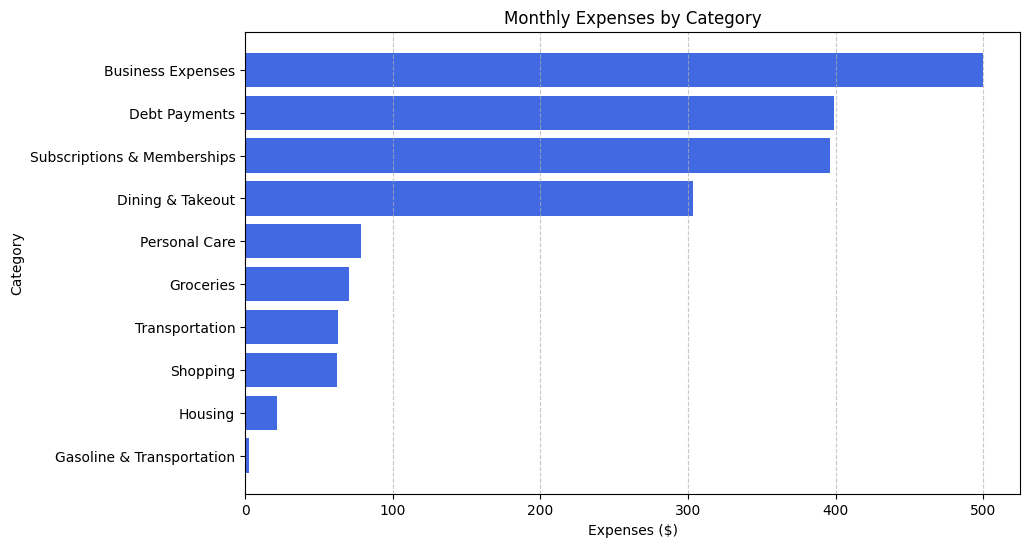

In [38]:
fig = plot_expense_by_category(current_pay_period)

In [ ]:
def plot_expense_by_category(df):
    current_expenses = df[df['Transaction_Type'] == 'Expense']
    current_expenses['abs_amount'] = current_expenses['Amount'].abs()

    expense_by_category = current_expenses.groupby('Category')['abs_amount'].sum().reset_index()
    expense_by_category = expense_by_category[expense_by_category['Category'] != 'Savings']
    expense_by_category = expense_by_category.sort_values(by='abs_amount', ascending=True)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10,6))

    # Create horizontal bar plot
    ax.barh(expense_by_category['Category'], expense_by_category['abs_amount'], color='royalblue')

    # Add labels and title
    ax.set_xlabel('Expenses ($)')
    ax.set_ylabel('Category')
    ax.set_title('Monthly Expenses by Category')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    return fig


In [14]:
def cash_flow_plot(df):
    # Format columns
    df['Date'] = pd.to_datetime(df['Date'])
    df['YearMonth'] = df['Date'].dt.to_period("M")

    # Aggregate monthly cash flow
    net_savings = df.groupby("YearMonth")["Amount"].sum().reset_index()

    # Create cash flow plot
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(net_savings["YearMonth"].astype(str), net_savings["Amount"], linestyle="-")

    return fig

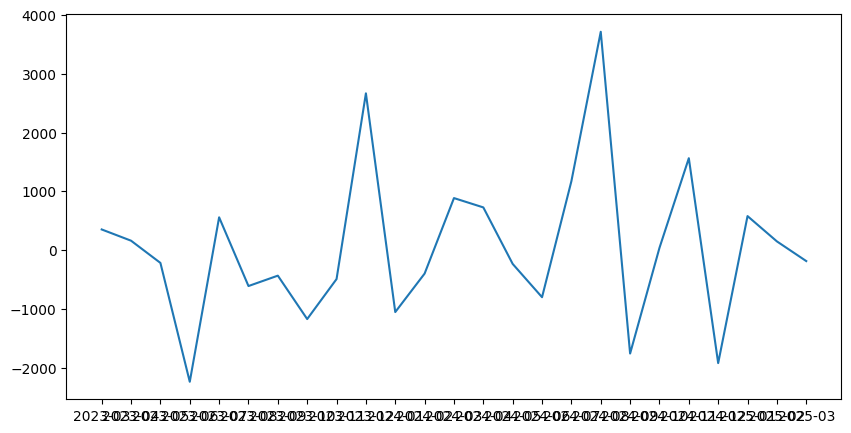

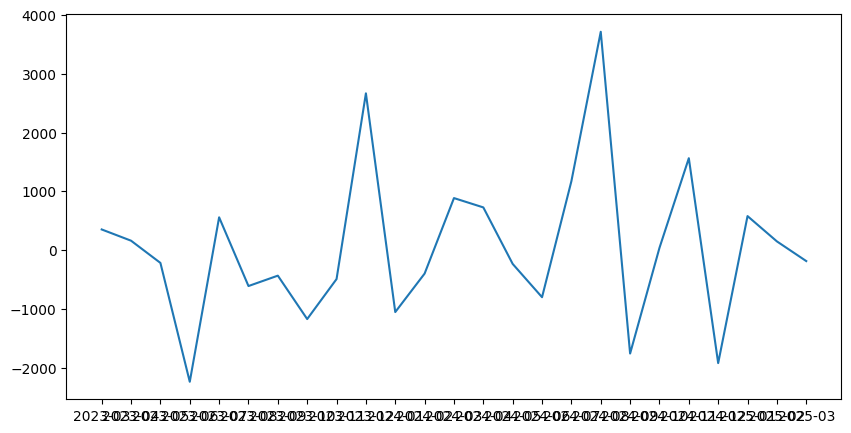

In [15]:
cash_flow_plot(transactions_df)

In [201]:
transactions_df['Date'] = pd.to_datetime(transactions_df['Date'])

In [202]:
transactions_df['YearMonth'] = transactions_df['Date'].dt.to_period("M")

In [203]:
# Aggregate monthly spending
net_savings = transactions_df.groupby("YearMonth")["Amount"].sum().reset_index()

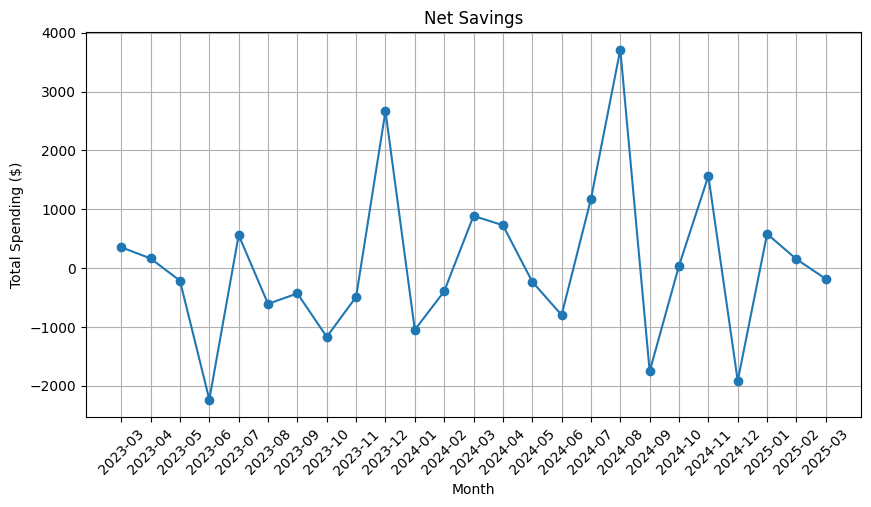

In [204]:
# Plot monthly spending
plt.figure(figsize=(10, 5))
plt.plot(net_savings["YearMonth"].astype(str), net_savings["Amount"], marker="o", linestyle="-")
plt.xlabel("Month")
plt.ylabel("Total Spending ($)")
plt.title("Net Savings")
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [205]:
def classify_expense_income(amount):
    if amount < 0:
        type_of_transaction = 'Expense'
    elif amount > 0:
        type_of_transaction = "Income"
    else:
        type_of_transaction = "Neutral"
    
    return type_of_transaction

In [206]:
transactions_df['Transaction_Type'] = transactions_df.apply(lambda row: classify_expense_income(amount=row["Amount"]), axis=1)

In [207]:
transactions_df['Abs_Amount'] = abs(transactions_df['Amount'])

In [208]:
# Create dataframe for expenses
expenses_df = transactions_df[transactions_df['Transaction_Type'] == 'Expense']

# Create dataframe for income transactions
income_df = transactions_df[transactions_df['Transaction_Type'] == 'Income']

In [209]:
# Aggregate monthly spending
monthly_spending = expenses_df.groupby("YearMonth")["Abs_Amount"].sum().reset_index()

In [210]:
# Aggregate monthly income
monthly_income = income_df.groupby("YearMonth")["Amount"].sum().reset_index()

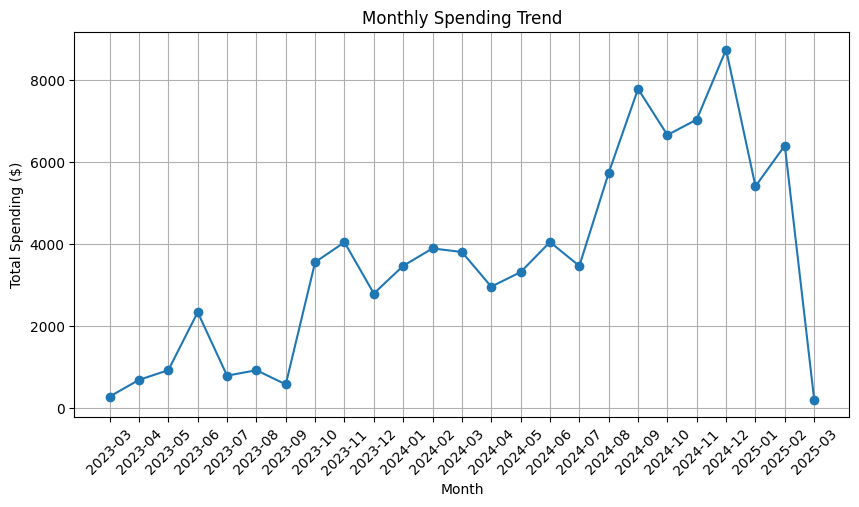

In [211]:
# Plot monthly spending
plt.figure(figsize=(10, 5))
plt.plot(monthly_spending["YearMonth"].astype(str), monthly_spending["Abs_Amount"], marker="o", linestyle="-")
plt.xlabel("Month")
plt.ylabel("Total Spending ($)")
plt.title("Monthly Spending Trend")
plt.xticks(rotation=45)
plt.grid()
plt.show()

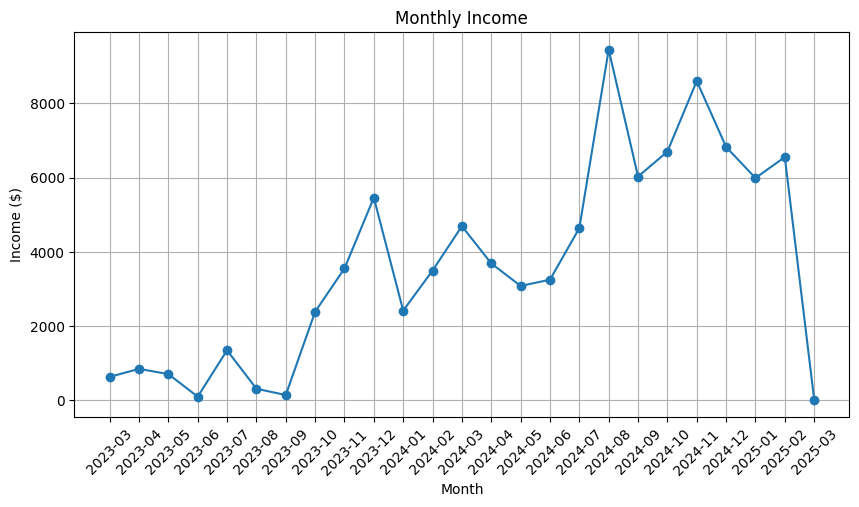

In [212]:
# Plot monthly spending
plt.figure(figsize=(10, 5))
plt.plot(monthly_income["YearMonth"].astype(str), monthly_income["Amount"], marker="o", linestyle="-")
plt.xlabel("Month")
plt.ylabel("Income ($)")
plt.title("Monthly Income")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [213]:
# Aggregate income vs expense
income_expense = transactions_df.groupby(["YearMonth", "Transaction_Type"])["Abs_Amount"].sum().unstack().fillna(0)

In [214]:
income_expense

Transaction_Type,Expense,Income
YearMonth,,
2023-03,280.96,632.86
2023-04,687.98,848.78
2023-05,925.37,708.45
2023-06,2338.35,100.00
2023-07,791.01,1349.38
2023-08,923.72,313.48
2023-09,577.45,143.82
2023-10,3560.19,2388.43
2023-11,4045.51,3553.63


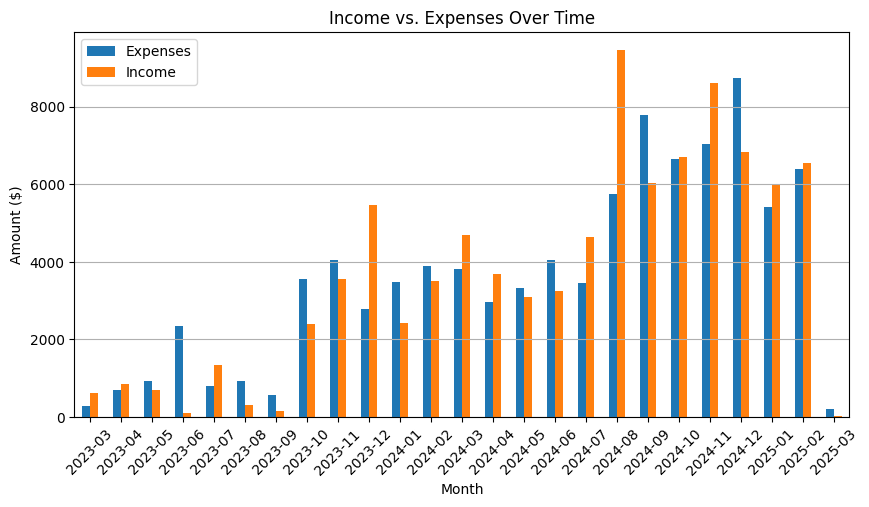

In [215]:
# Plot bar chart
income_expense.plot(kind="bar", figsize=(10, 5))
plt.xlabel("Month")
plt.ylabel("Amount ($)")
plt.title("Income vs. Expenses Over Time")
plt.xticks(rotation=45)
plt.legend(["Expenses", "Income"])
plt.grid(axis="y")
plt.show()

In [ ]:
amex_transactions = transactions_df[transactions_df['Bank'] == 'AMEX']

In [ ]:
total_car_lease = 14364
nss_total_amount = 8625

np.float64(38.47)

In [ ]:
total_car_lease_paid = expenses_df[expenses_df['Description'].str.contains("CHRYSLER CAPITAL")]['Amount'].sum()
nss_total_paid = transactions_df[transactions_df['Description'].str.contains("NASHVILLE SOFTWARE")]['Amount'].sum()
car_lease_balance = round((total_car_lease + total_car_lease_paid),2)
credit_card_balance = round(amex_transactions['Amount'].sum(),2)
nss_school_balance = (nss_total_amount + nss_total_paid)

In [8]:
import sys
from pathlib import Path
SOURCE_DIR = Path.cwd().parent / 'src'

In [4]:
sys.path.append(SOURCE_DIR)

In [7]:
from src.budget_analysis import plot_expense_by_category

ModuleNotFoundError: No module named 'src'